# Restaurants in Taipei EDA & Data Visualization Project

For this project, I would like to analyze the restaurants' data to answer the following questions: <br>

<ol>
<li> How many restaurants in each districts? </li> 
<li> How is the rating distribution in each districts? </li> 
<li> Are certain types of cuisines more represented in some areas than in others? </li> 
<li> Are certain types of cuisines more represented in some districts than in others? </li>
<li> Is rating and average price spent by person in a restaurant correlated? </li> 
<li> Which district get highest price median & which get wider price range? </li>
<li> The correlation between the amount of restaurants in a district and socioeconomic factors </li>     </ol>

In [103]:
import pandas as pd
import numpy as np
import geopandas as gpd

from functools import reduce
from unicodedata import normalize

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium 
import seaborn as sns
import plotly.express as px
from bokeh.models import ColumnDataSource, Whisker
from bokeh.plotting import figure, show, output_file, save
from bokeh.sampledata.autompg2 import autompg2 as df
from bokeh.transform import factor_cmap, jitter
from bokeh.palettes import brewer
import circlify


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [104]:
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'/Users/yuyi/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf',size=14)
sns.set(font=myfont.get_family())
sns.set_style("whitegrid",{"font.sans-serif":['SimHei']})

# to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [105]:
# using geopandas to read .shp file, 
# set encoding='utf-8' to read chinese characters
districts = gpd.read_file('/Users/yuyi/Downloads/mapdata202209220431/TOWN_MOI_1100415.shp', 
                          encoding='utf-8')


# import the pre-cleaned restaurant data
df = pd.read_csv('/Users/yuyi/Desktop/project_ifoodie/ifoodie_1.csv')

## Q1: How many restaurants in each districts?

In [106]:
# the amount of restaurants in each districts
res_by_district = df.groupby('district')['title'].count()

# from .count() return a serie, .to_frame can convert the serie to dataframe
res_by_district_df = res_by_district.to_frame()


print(res_by_district)

district
中山區    1487
中正區     805
信義區     875
內湖區     492
北投區     266
南港區     198
士林區     663
大同區     580
大安區    1854
文山區     232
松山區     779
萬華區     492
Name: title, dtype: int64


### Preparing for visualization

In [107]:
# select the rows of taipei city and keep necessary columns only
tpe_dist = districts[districts['COUNTYNAME'] == '臺北市']
tpe_dist = tpe_dist[['TOWNNAME', 'TOWNENG', 'geometry']]
tpe_dist = tpe_dist.rename(columns={'TOWNNAME':'行政區'})


# joining res_by_district
res_by_district_geo = pd.merge(tpe_dist, res_by_district, left_on='行政區', right_on='district' ).sort_values('title')

#res_by_district_geo_json = res_by_district_geo.to_json()

# reset indesx from '行政區' to TOWNENG, so later '行政區' can be used as a column to plot the map
res_by_district_geo = res_by_district_geo.set_index('TOWNENG')
res_by_district_geo = res_by_district_geo.rename(columns={'title':'餐廳數'})

print(res_by_district_geo)

                     行政區                                           geometry  \
TOWNENG                                                                       
Nangang District     南港區  POLYGON ((121.61425 25.06451, 121.61425 25.064...   
Wenshan District     文山區  POLYGON ((121.59725 25.01439, 121.59724 25.014...   
Beitou District      北投區  POLYGON ((121.55990 25.21014, 121.56010 25.210...   
Wanhua District      萬華區  POLYGON ((121.50521 25.04949, 121.50554 25.049...   
Neihu District       內湖區  POLYGON ((121.59359 25.11515, 121.59368 25.115...   
Datong District      大同區  POLYGON ((121.51410 25.07942, 121.51488 25.079...   
Shilin District      士林區  POLYGON ((121.58088 25.19535, 121.58101 25.195...   
Songshan District    松山區  POLYGON ((121.56971 25.07629, 121.56981 25.076...   
Zhongzheng District  中正區  POLYGON ((121.51341 25.04940, 121.51375 25.049...   
Xinyi District       信義區  POLYGON ((121.57995 25.04950, 121.57996 25.049...   
Zhongshan District   中山區  POLYGON ((121.54147 25.092

In [108]:
# get center coordinates for each district
res_by_district_geo['centroid'] = res_by_district_geo.centroid


# create new columns for x,y 
res_by_district_geo['x'] = res_by_district_geo['centroid'].apply(lambda t: t.x)
res_by_district_geo['y'] = res_by_district_geo['centroid'].apply(lambda t: t.y)


print(res_by_district_geo[['x','y']])

                              x          y
TOWNENG                                   
Nangang District     121.609767  25.036053
Wenshan District     121.573978  24.988655
Beitou District      121.517835  25.148199
Wanhua District      121.497348  25.029368
Neihu District       121.592398  25.083782
Datong District      121.513207  25.064005
Shilin District      121.550870  25.125605
Songshan District    121.557754  25.059802
Zhongzheng District  121.519848  25.032457
Xinyi District       121.571652  25.030754
Zhongshan District   121.538338  25.069852
Da'an District       121.543424  25.026865


### The amount of restaurant in each district visualized on the interactive map

In [109]:
# plot the choropleth map
m = res_by_district_geo.explore(column='餐廳數', 
                                tooltip='行政區', popup=True,  
                                tiles="CartoDB positron", 
                                cmap='Oranges', style_kwds=dict(color="orange"))




# add labels - district name and the amount of restaurants 
for i in range(0, len(res_by_district_geo)):
    locations = (res_by_district_geo.iloc[i]['y']+0.009, res_by_district_geo.iloc[i]['x']-0.003)
    
 
    folium.Marker(
        location =locations,
        popup=res_by_district_geo.iloc[i]['行政區'],
        icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: black; font-size: 14px; font-weight: bold">{res_by_district_geo.iloc[i]['行政區']}{res_by_district_geo.iloc[i]['餐廳數']}</div>""")).add_to(m)
m



## Q2: How is the rating distribution in each districts?

In [110]:
# extract needed columns to new dataframe
rating_df = df[['title','district', 'rating']]

# cluter the rating into 5 groups  (1,2,3,4,5) by converting float to int
rating_df['rating'] = rating_df['rating'].astype('int')

# using pd.crosstab to produce the percetage of each rating in each district
rating_crosstab = pd.crosstab(index=rating_df['district'], columns=rating_df['rating'], normalize='index').round(4)*100


print(rating_crosstab)

rating       1     2      3      4     5
district                                
中山區       0.40  0.87  13.25  84.40  1.08
中正區       0.50  1.61  16.89  80.62  0.37
信義區       1.03  1.03  14.63  81.49  1.83
內湖區       1.42  0.20  14.23  81.71  2.44
北投區       0.00  0.75  17.29  80.08  1.88
南港區       0.51  1.01  17.17  81.31  0.00
士林區       0.90  0.75  17.65  80.24  0.45
大同區       0.00  1.21  18.10  78.45  2.24
大安區       0.43  0.32  11.54  85.92  1.78
文山區       0.00  0.00  15.52  83.62  0.86
松山區       0.64  0.64  13.99  82.93  1.80
萬華區       0.41  1.22  16.46  79.88  2.03


### Percentage of ratings in each districts visualized on a horizontal bar chart 

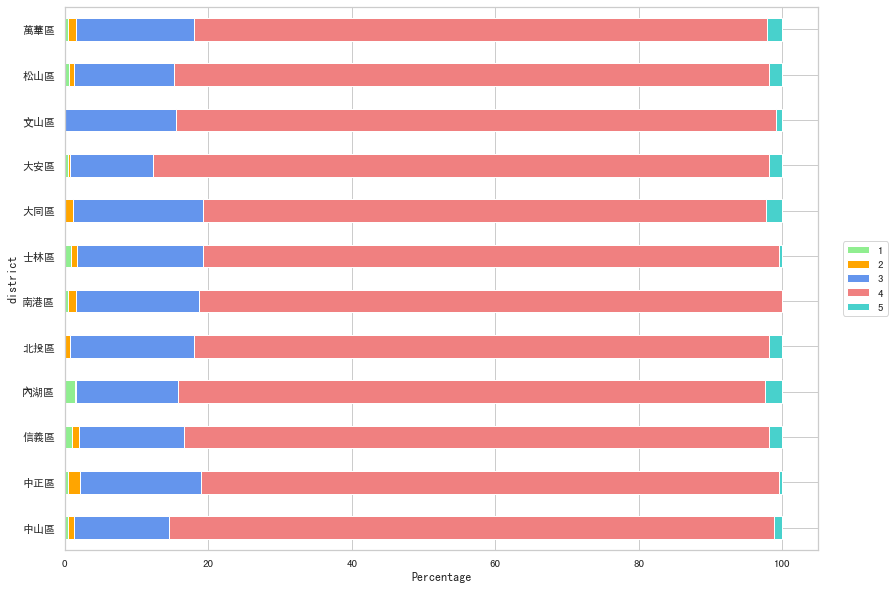

In [111]:
# prepare color palette for bar chart 
colors=[ 'lightgreen', 'orange', 'cornflowerblue', 'lightcoral', 'mediumturquoise']


# plot the chart
fig, ax = plt.subplots(figsize=(15, 10))
rating_crosstab.plot(kind='barh', stacked=True, color=colors, ax=ax)
plt.xlabel("Percentage")

# Add legend which is outside the chart
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width*0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))


#plt.savefig('rating_by_district.png')
plt.show()

## Q3: Which ethinic crusine has the highest amount of restaurants in taipei?

In [112]:
# strip off the '[]'
df['categories'] = df['categories'].apply(lambda x: x[1:-1])


# expand the categories into seperated columns, 
# and count the restaurants by district and categories
new_df = df.assign(categories=df['categories'].str.split(', ')).explode('categories')\
            .groupby(["district", "categories"])["title"].count()

         
# use reset_index() to flattern the multi-level index created by groupby()
new_df = pd.DataFrame(new_df).reset_index().sort_values(['district', 'title'], ascending=False)


# reset column name
new_df.rename(columns = {'title':'restaurant_count'}, inplace=True)


# checking unique value in the columns
district_list = list(new_df['district'].unique())
category_list = list(new_df['categories'].unique())

# extract crusines from categories
crusine_filter = ['日本料理', '義式料理', '中式料理', '港式料理', '韓式料理',  '泰式料理', '越式料理',
                  '美式料理', '新加坡料理','墨西哥料理', '德國料理', '法式料理']


In [113]:
print(category_list)

['午餐', '晚餐', '小吃', '宵夜', '日本料理', '火鍋', '甜點', '約會餐廳', '下午茶', '精緻高級', '合菜', '冰品飲料', '燒烤', '咖啡', '早餐', '早午餐', '義式料理', '中式料理', '居酒屋', '牛肉麵', '酒吧', '餐酒館', '拉麵', '港式料理', '蛋糕', '牛排', '咖哩', '素食', '精品咖啡', '韓式料理', '飲料店', '新開幕', '麵食', '輕食', '外帶外送店家', '泰式料理', '海鮮', '美式料理', '茶店', '壽司', '寵物友善', '漢堡', '烘焙坊', '冰淇淋', '刨冰', '啤酒', '熱炒', '親子餐廳', '鐵板燒', '雞料理', '鬆餅', '外帶優惠店家', '愛食卡精選店家', 'Buffet', '景觀餐廳', '異國料理', '越式料理', '涮涮鍋', '披薩', '新加坡料理', '餃子', '餐酒館/酒吧', '三明治', '墨西哥料理', '德國料理', '法式料理', '果汁吧', '攤販']


In [114]:
# get top 5 crusines in each district
district_crusine = new_df[new_df['categories'].isin(crusine_filter)]
top5_district_crusine = district_crusine.groupby('district').head(5).reset_index(drop=True)
print(top5_district_crusine)

   district categories  restaurant_count
0       萬華區       日本料理                75
1       萬華區       義式料理                25
2       萬華區       中式料理                22
3       萬華區       港式料理                12
4       萬華區       韓式料理                 7
5       松山區       日本料理               116
6       松山區       義式料理                68
7       松山區       中式料理                51
8       松山區       港式料理                26
9       松山區       韓式料理                21
10      文山區       日本料理                20
11      文山區       中式料理                18
12      文山區       義式料理                16
13      文山區       港式料理                 8
14      文山區       美式料理                 3
15      大安區       日本料理               322
16      大安區       義式料理               173
17      大安區       中式料理               144
18      大安區       港式料理                55
19      大安區       韓式料理                37
20      大同區       日本料理                78
21      大同區       中式料理                33
22      大同區       義式料理                27
23      大同區     

In [115]:
# expand the categories list in each restaurant and count the amount of restaurants in each categories
tpe_count_by_category = df.assign(categories=df['categories'].str.split(', ')).explode('categories')\
            .groupby(["categories"])["title"].count()
tpe_count_by_category = pd.DataFrame(tpe_count_by_category).reset_index()\
            .sort_values('title', ascending=False)

# extract the ethinic crusines 
tpe_crusine = tpe_count_by_category[tpe_count_by_category['categories'].isin(crusine_filter)]
print(tpe_crusine)




   categories  title
27       日本料理   1421
52       義式料理    694
3        中式料理    619
37       港式料理    261
61       韓式料理    193
51       美式料理     92
34       泰式料理     38
56       越式料理      8
20       德國料理      2
25      新加坡料理      2
12      墨西哥料理      1
33       法式料理      1


### The amount of restaurants in each crusine visualized on an interactive bubble chart 

In [116]:
# add X and Y columns 
tpe_crusine['Y'] = [1]*len(tpe_crusine)
list_x = list(range(0,len(tpe_crusine)))
tpe_crusine['X'] = list_x



# get a color list for the number of crusines
pal_ = list(sns.color_palette(palette='plasma_r',
                              n_colors=len(crusine_filter)).as_hex())

# create a lable list for each bubble 
label = [i+'<br>'+str(j)+'<br>' for i,j in zip(tpe_crusine.categories, tpe_crusine.title)]


# plot the bubbles 
fig = px.scatter(tpe_crusine, x='X', y='Y',
                 color='categories', color_discrete_sequence=pal_,
                 size='title', text=label, size_max=90)

fig.update_layout(width=900, height=320,
                  margin = dict(t=50, l=0, r=0, b=0),
                  showlegend=False)

fig.update_traces(textposition='top center')
fig.update_xaxes(showgrid=False, zeroline=False, visible=False)
fig.update_yaxes(showgrid=False, zeroline=False, visible=False)
fig.update_layout({'plot_bgcolor': 'white',
                   'paper_bgcolor': 'white'})

#fig.write_image("crusine_restaurant_count.png")
fig.show()

## Q4: Are certain types of cuisines more represented in some districts than in others?

In [117]:
# use reset_index() to flattern the multi-level index created by groupby()  
new_df1 = pd.DataFrame(new_df).reset_index()\
                            .sort_values(['categories', 'restaurant_count'], ascending=False)

new_df1 = new_df1[new_df1['categories'].isin(crusine_filter)]


# add the column showing porpotion of restaurant count in each categroy by district
g = new_df1.groupby("categories")['restaurant_count'].transform('sum')
new_df1['proportion'] = new_df1['restaurant_count'] / g * 100
new_df1['proportion'] = new_df1['proportion'].round(1)

# get top district for each crusine
top_district_by_crusine = new_df1.groupby('categories').head(1).reset_index(drop=True).sort_values('restaurant_count', ascending=False)

#print(top_district_by_crusine)
print(top_district_by_crusine)

    index district categories  restaurant_count  proportion
7      22      中山區       日本料理               332        23.4
2     459      大安區       義式料理               173        24.9
11    414      大安區       中式料理               144        23.3
4      30      中山區       港式料理                57        21.8
0     467      大安區       韓式料理                37        19.2
3     458      大安區       美式料理                22        23.9
5     135      信義區       泰式料理                 8        21.1
1     156      信義區       越式料理                 4        50.0
8     434      大安區      新加坡料理                 2       100.0
6     441      大安區       法式料理                 1       100.0
9     430      大安區       德國料理                 1        50.0
10    422      大安區      墨西哥料理                 1       100.0


### The restaurant distribution in each district grouped by crusines visualized on bubble map

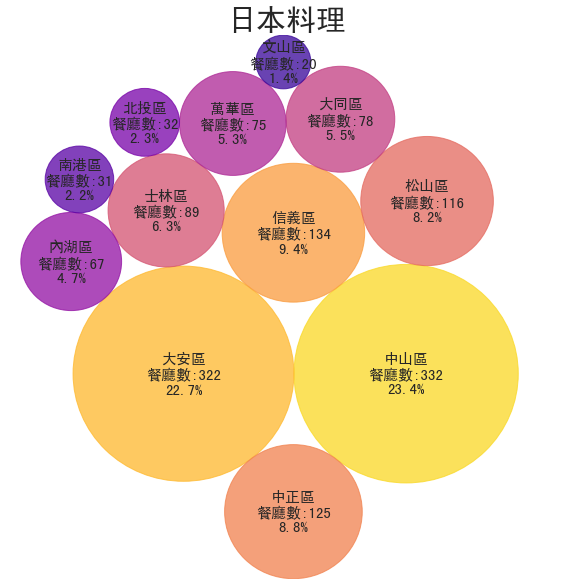

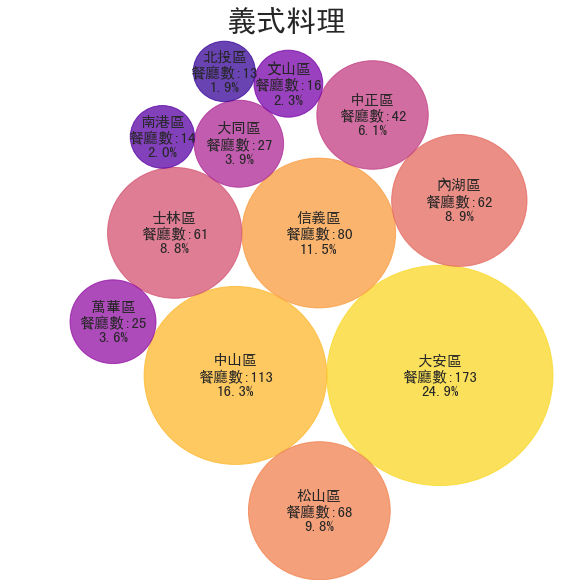

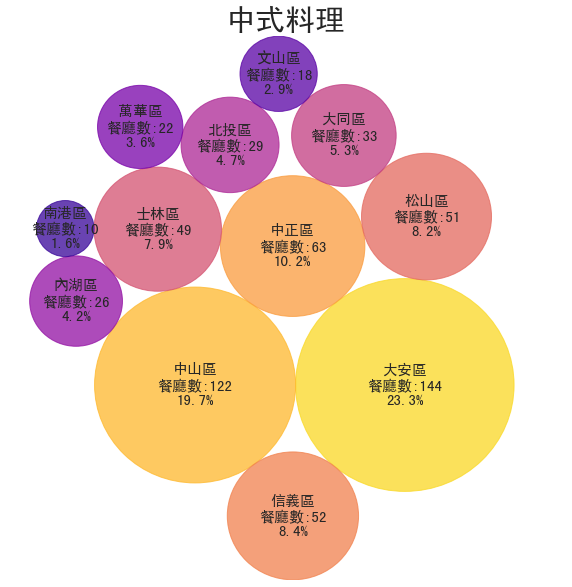

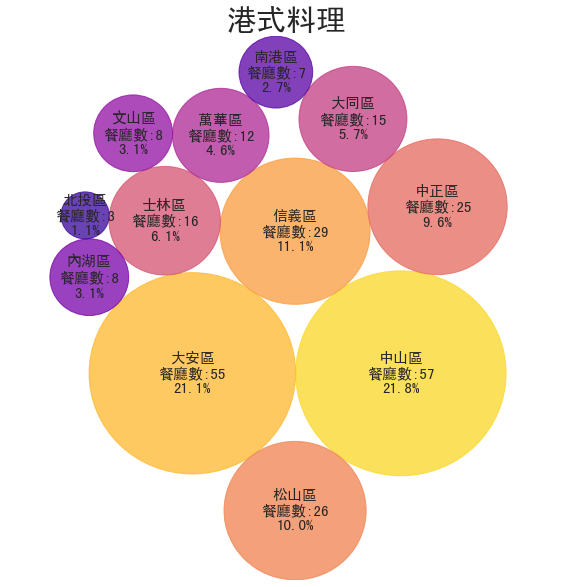

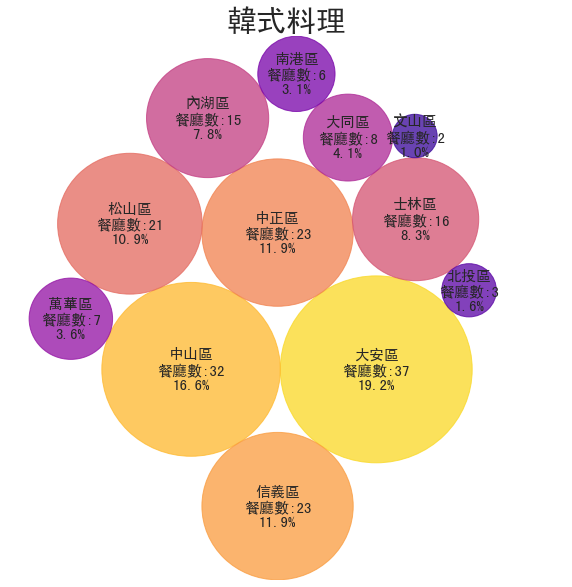

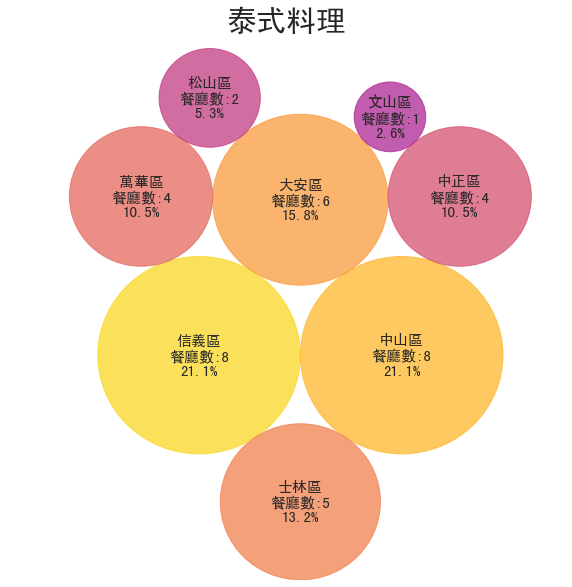

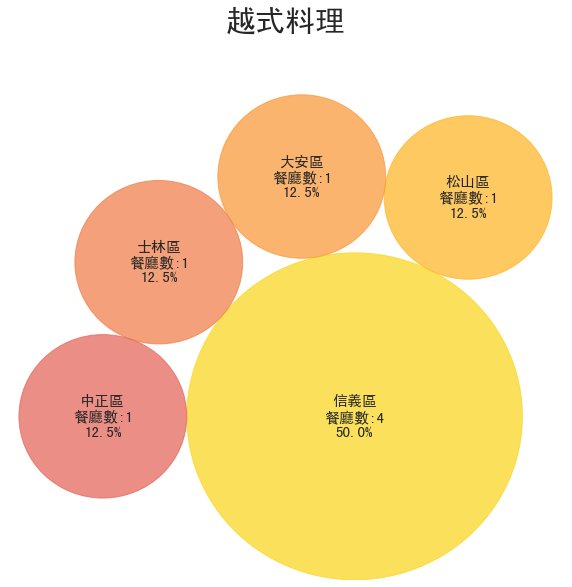

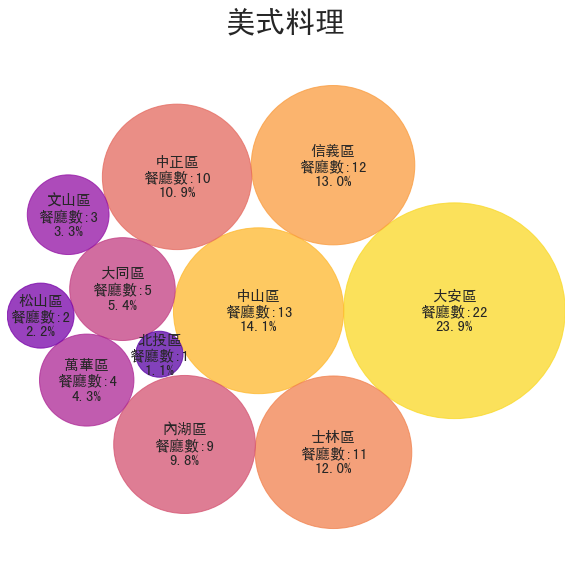

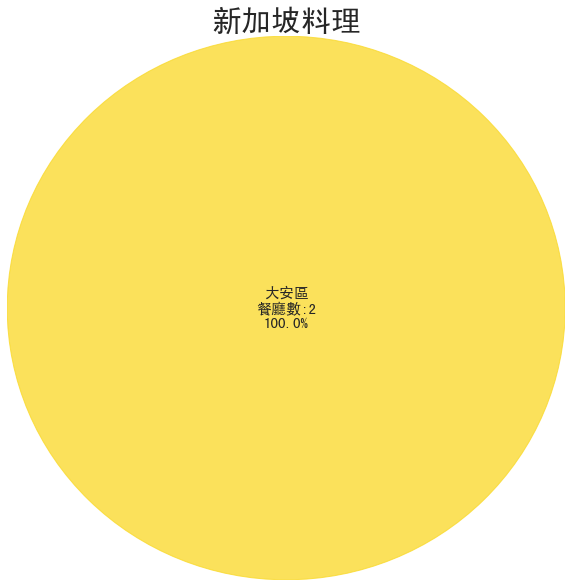

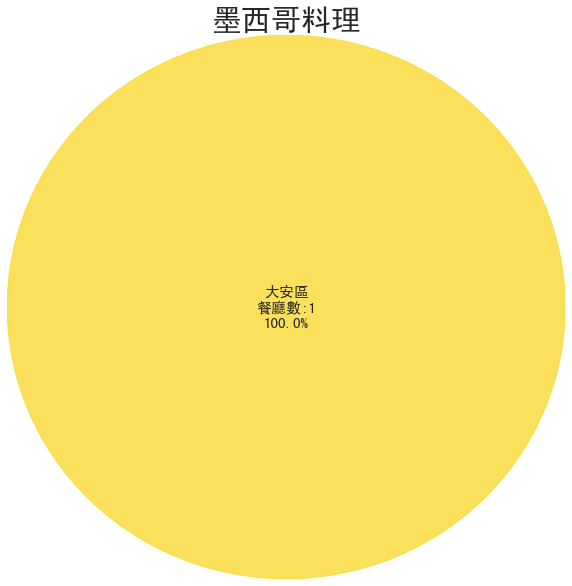

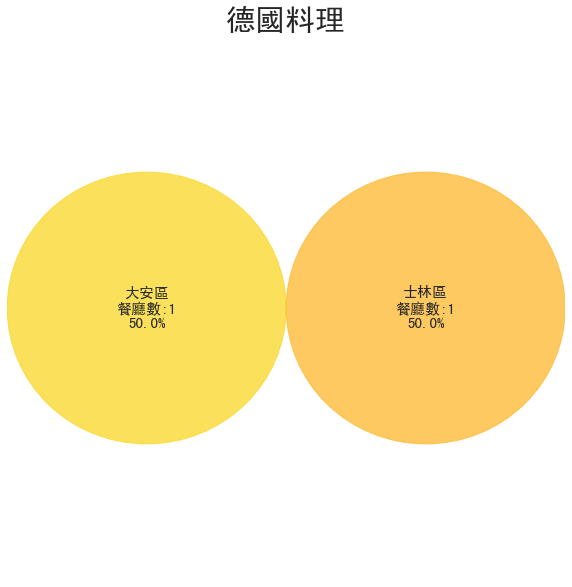

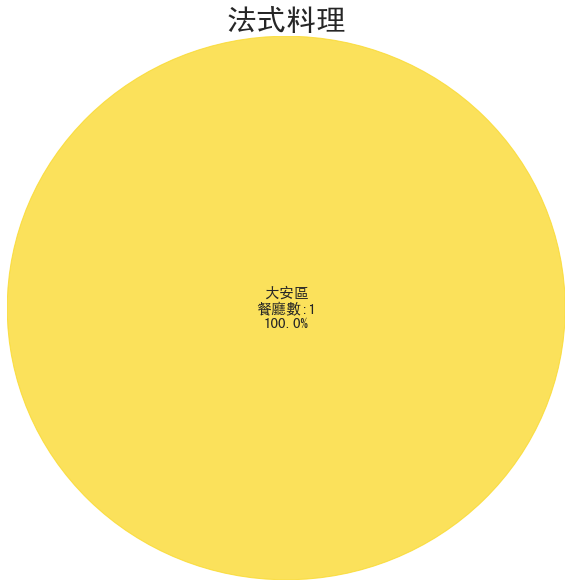

In [118]:
for crusine in crusine_filter:
    # compute circle positions:
    circles = circlify.circlify(new_df1[new_df1['categories']==crusine]['restaurant_count'].tolist(), 
                                show_enclosure=False, 
                                target_enclosure=circlify.Circle(x=0, y=0))
    circles.reverse()
    
    #create a laebls list for each bubble 
    label = [i+'<br>'+'餐廳數:'+str(j)+'<br>'+str(k)+'%' for i,j,k in zip(new_df1[new_df1['categories']==crusine]['district'],
                                                                new_df1[new_df1['categories']==crusine]['restaurant_count'],
                                                                new_df1[new_df1['categories']==crusine]['proportion'])]
    
    # plot the bubbles
    fig, ax = plt.subplots(figsize=(10,10), facecolor='white')
    ax.axis('off')
    lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # print circles
    for circle, note, color in zip(circles, label, pal_):
        x, y, r = circle
        ax.add_patch(plt.Circle((x, y), r, alpha=0.75, color = color))
        plt.annotate(note.replace('<br>','\n'), (x,y), size=15, va='center', ha='center')
    plt.xticks([])
    plt.yticks([])
    plt.title(crusine, fontsize=30)
    #plt.savefig("Graph" + str(crusine) +".png", format="PNG")

plt.show()

## Q5: Is rating and average price spent by person in a restaurant correlated?

In [119]:
# crusine v.s. rating(x) v.s. price(y) (scatter) 

# expand the categories into seperated columns, 
# and count the restaurants by categories and district
new_df2 = df.assign(categories=df['categories'].str.split(', ')).explode('categories')
       
# groupby create multi-level index so I flatterning it by reset_index(),     
new_df2 = pd.DataFrame(new_df2).reset_index().sort_values(['categories', 'rating'], ascending=False)


cuisine_filter2 = ['日本料理', '義式料理', '中式料理', '港式料理', '韓式料理',  '泰式料理', '越式料理',
                  '美式料理']
new_df2 = new_df2[new_df2['categories'].isin(crusine_filter2)]


### Average amount spent per person v.s. rating grouped by cuisines visualized on scatter plots

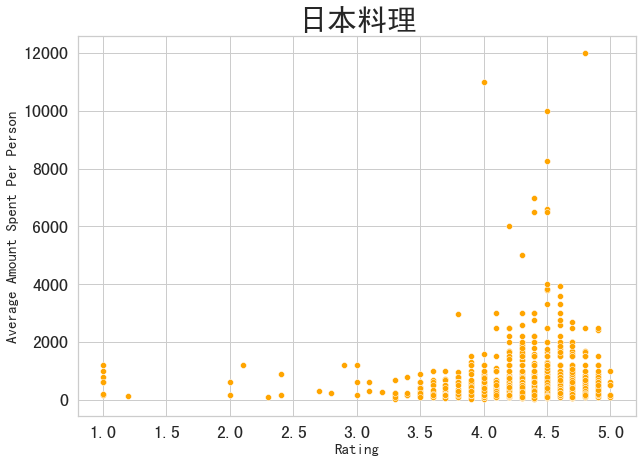

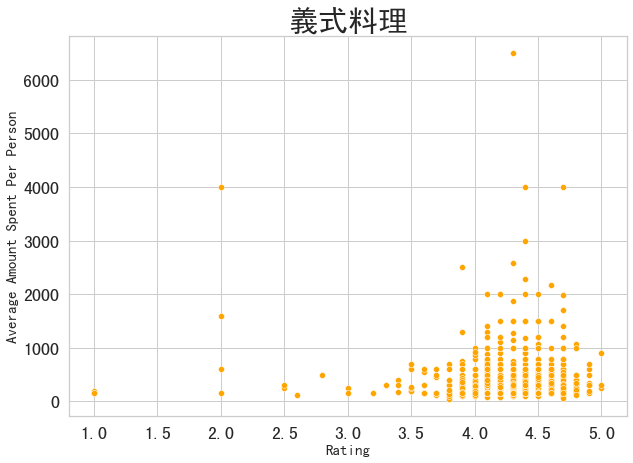

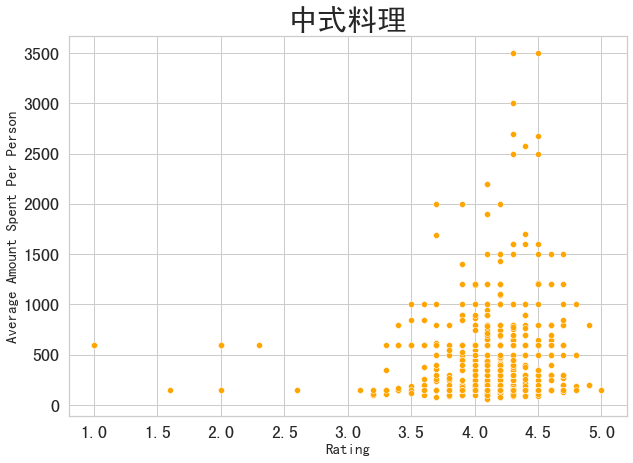

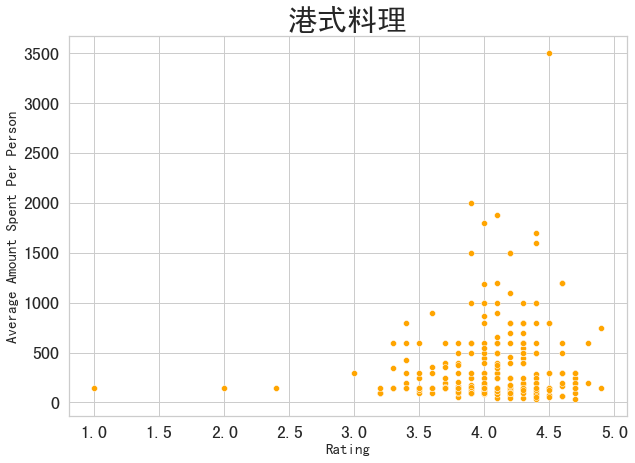

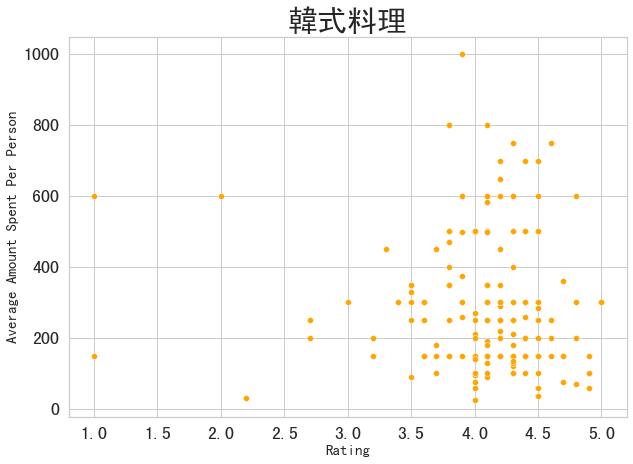

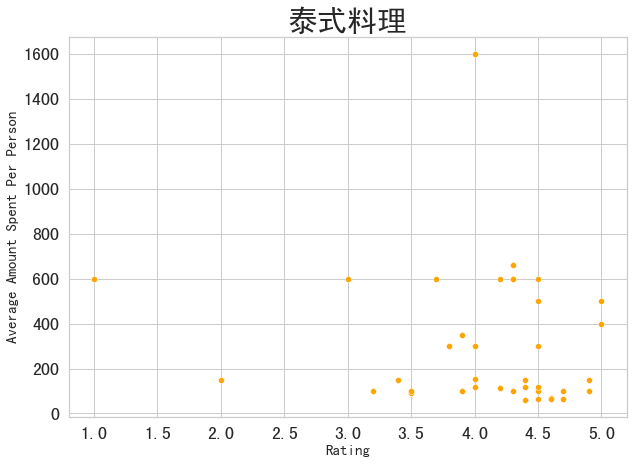

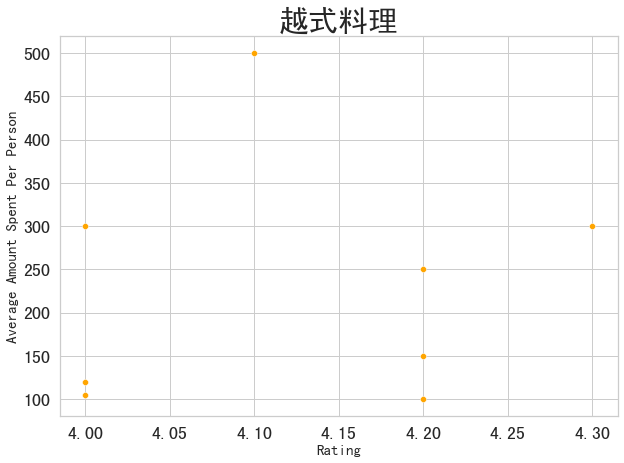

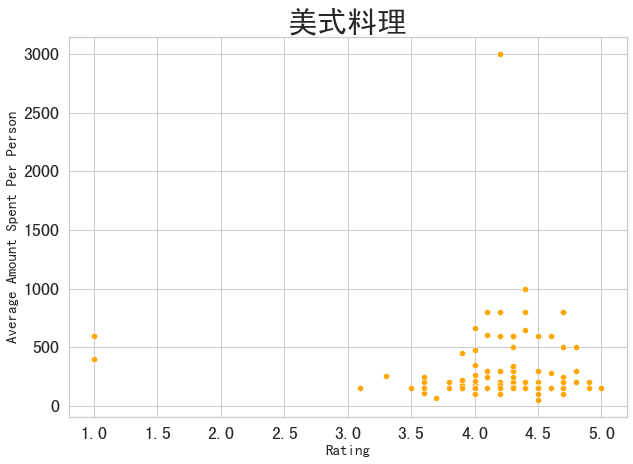

In [120]:
# use loop to generate the chart for each cuisine
for cuisine in cuisine_filter2:
    
    fig, ax = plt.subplots(figsize=(10,7))
    sns.scatterplot(data=new_df2[new_df2['categories']==cuisine], x='rating', y='avg_price', 
                                        color='orange').set_title(cuisine, fontdict = {'fontsize': 30})
    
    # set the tick size
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # set the label size
    plt.xlabel('Rating', fontsize=15)
    plt.ylabel('Average Amount Spent Per Person', fontsize=15)

    
    plt.savefig("scatter" + str(crusine) +".png", format="PNG")
    plt.show()

In [121]:
# compute the correlation coefficient with .corr

df['avg_price'].corr(df['rating'])

0.07198689071588125

## Q6: which district get highest price median & which get wider price range (max-min)

In [122]:
avg_price_df = df[['district', 'avg_price']]


# compute quantiles
qs = avg_price_df.groupby("district").avg_price.quantile([0.25, 0.5, 0.75])
qs = qs.unstack().reset_index()
qs.columns = ["district", "q1", "q2", "q3"]
avg_price_df = pd.merge(avg_price_df, qs, on="district", how="left")

# compute IQR outlier bounds
iqr = avg_price_df.q3 - avg_price_df.q1
avg_price_df["upper"] = avg_price_df.q3 + 1.5*iqr
avg_price_df["lower"] = avg_price_df.q1 - 1.5*iqr

source = ColumnDataSource(avg_price_df)

sorted_district_list = list(df.groupby(by=["district"])["avg_price"].median().sort_values(ascending=True).index)





### Average price distribution in each district visualized on the interactive box plot

In [123]:
color = list(brewer['Set3'][12])


p = figure(x_range=sorted_district_list, 
           tools=['wheel_zoom', 'pan'], toolbar_location='left', toolbar_sticky=False,
           title="Average Price Ditribution by Districts",
           background_fill_color="#eaefef", y_axis_label="Average Amount Spent Per Person")


# add whisker - outlier range
whisker = Whisker(base="district", upper="upper", lower="lower", source=source)
whisker.upper_head.size = whisker.lower_head.size = 20
p.add_layout(whisker)


# quantile boxes
cmap = factor_cmap("district", color, sorted_district_list)
p.vbar("district", 0.7, "q2", "q3", source=source, color=cmap, line_color="black")
p.vbar("district", 0.7, "q1", "q2", source=source, color=cmap, line_color="black")


# outliers
outliers = avg_price_df[~avg_price_df.avg_price.between(avg_price_df.lower, avg_price_df.upper)]
p.scatter("district", "avg_price", source=outliers, size=6, color="black", alpha=0.3)


p.xgrid.grid_line_color = None
p.axis.major_label_text_font_size="14px"
p.axis.axis_label_text_font_size="12px"

p.width = 900
p.height = 600


#output_file(filename="AvgPrice_by_districts.html", title="average price ditribution by districts")

show(p)


In [130]:
print(df.groupby(by=["district"])["avg_price"].describe().round())

print('------------------------------------------------------------')

# the most expensive restaurants
highest_price = [12000.0, 11000.0, 10000.0]
print(df[df["avg_price"].isin(highest_price)][['title', 'avg_price']])


           count   mean    std   min    25%    50%    75%      max
district                                                          
中山區       1487.0  499.0  694.0  12.0  150.0  300.0  600.0  12000.0
中正區        805.0  288.0  307.0  14.0  120.0  180.0  330.0   2700.0
信義區        875.0  485.0  709.0  30.0  150.0  300.0  600.0  10000.0
內湖區        492.0  326.0  446.0  20.0  150.0  178.0  385.0   6000.0
北投區        266.0  284.0  359.0   6.0  150.0  150.0  300.0   3000.0
南港區        198.0  307.0  253.0  30.0  150.0  200.0  400.0   1100.0
士林區        663.0  336.0  355.0  14.0  150.0  200.0  450.0   4000.0
大同區        580.0  264.0  289.0  15.0  114.0  150.0  300.0   3500.0
大安區       1854.0  485.0  632.0  25.0  150.0  300.0  600.0  11000.0
文山區        232.0  244.0  207.0  13.0  120.0  150.0  315.0   2000.0
松山區        779.0  416.0  571.0  18.0  150.0  250.0  550.0   8250.0
萬華區        492.0  274.0  250.0   5.0  124.0  150.0  352.0   1500.0
------------------------------------------------------------
 

## Q7: The correlation between the amount of restaurants in a district and socioeconomic factors 

In [125]:
#import open data and cleaning

population = pd.read_csv('/Users/yuyi/Desktop/project_ifoodie/population_tpe.csv')
population = population[population['月份']==8]
population = population.drop(
    columns=(['月份','里數_現有門牌', '里數_戶籍登記', '鄰數_現有門牌', '鄰數_戶籍登記'])).reset_index(drop=True)
population = population.drop([0])


income = pd.read_csv('/Users/yuyi/Desktop/project_ifoodie/income.csv')
income = income[income['年別'] == '109年']
income = income[['行政區', '所得收入者人數[人]', '[一]所得收入總計[元]',  '[三]可支配所得[元]']]
income = income.rename(columns={'所得收入者人數[人]':'所得收入者人數',
                                '[一]所得收入總計[元]':'所得收入總計',
                                '[三]可支配所得[元]':'可支配所得'})
income = income.reset_index(drop=True).drop([0])



establishments_by_sector = pd.read_csv('/Users/yuyi/Desktop/project_ifoodie/establishments.csv')
establishments_by_sector = establishments_by_sector.drop(columns='總數')
establishments_by_sector = establishments_by_sector[['行政區','批發及零售業', '藝術、娛樂及休閒服務業']] 

establishments = pd.read_csv('/Users/yuyi/Desktop/project_ifoodie/臺北市工業及服務業場所單位經營概況.csv')
establishments = establishments.drop(columns=(['年底場所單位數_家_獨立經營單位_Number_of_establishment_units_end_of_2016_Establishment_Independent_operating_units',
                  '年底場所單位數_家_總管理單位_Number_of_establishment_units_end_of_2016_Establishment_Corporate_managing_units',
                  '年底場所單位數_家_分支單位_Number_of_establishment_units_end_of_2016_Establishment_Branch_units',
                  '全年薪資_千元_Payrolls_year-round_of_2016_NT1000',
                  '全年生產總額_千元_Total_value_of_production_year-round_of_2016_NT1000',
                  '年底實際運用固定資產淨額_千元_Net_value_of_fixed_assets_used_in_operation_end_of_2016_NT1000',
                  'District']))
establishments = establishments.drop([0])
establishments = establishments.rename(columns={'年底場所單位數_家_總計_Number_of_establishment_units_end_of_2016_Establishment_Total':'場所總數',
                '年底從業員工人數_人_Number_of_persons_engaged_end_of_2016_Person':'從業人數'}).reset_index(drop=True)
establishments = establishments.rename(columns={'行政區別':'行政區'})


res_by_district_copy = res_by_district.reset_index()
res_by_district_copy.rename(columns={'district' : '行政區', 'title':'ifoodie餐廳數'}, inplace=True)


dfs = [population, income, establishments_by_sector, establishments, res_by_district_copy]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['行政區'], how='outer'), dfs)

### visualized on correlation heatmap

<AxesSubplot:>

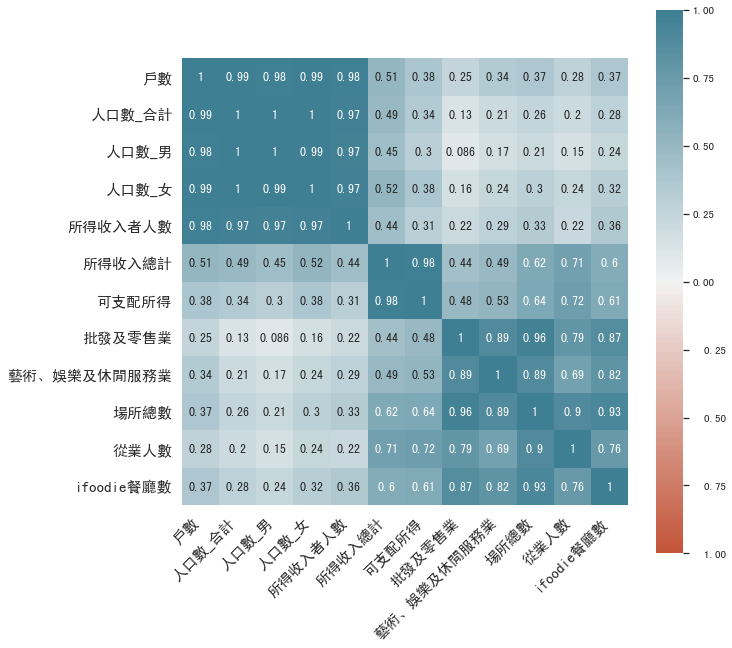

In [126]:
corr = final_df.corr()

fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

# set the tick size
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('corr_matrix.png')
ax